In [3]:
import os
import sys

sys.path.append("../python")

import matplotlib.pyplot as plt
import numpy as np

from gurobipy import Model, GRB

from data import Dataloader
from models import RandomExampleModel, TwoClustersMIP
import metrics

In [4]:
# Loading the data
data_loader = Dataloader("../data/dataset_4") # Specify path to the dataset you want to load
X, Y = data_loader.load()
X.shape

(2000, 4)

In [ ]:
# Get 400 pairs
X, Y = X[:400], Y[:400]

In [5]:
n_pieces = 5
n_clusters = 2
model = TwoClustersMIP(n_pieces, n_clusters)
model.fit(X, Y)

Set parameter Username


Academic license - for non-commercial use only - expires 2025-01-29
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10044 rows, 8048 columns and 123576 nonzeros
Model fingerprint: 0xbb12e97a
Variable types: 4048 continuous, 4000 integer (4000 binary)
Coefficient statistics:
  Matrix range     [1e-06, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 1e+03]
Presolve removed 10 rows and 8 columns
Presolve time: 0.45s
Presolved: 10034 rows, 8040 columns, 111680 nonzeros
Variable types: 4040 continuous, 4000 integer (4000 binary)

Root relaxation: objective 0.000000e+00, 6041 iterations, 2.70 seconds (2.96 work units)
Total elapsed time = 5.95s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Ob

<gurobi.Model MIP instance TwoClustersMIP: 10044 constrs, 8048 vars, Parameter changes: Username=(user-defined)>

In [6]:
model.save_model("../tmp/model_all")

Model saved


In [13]:
n_pieces = 5
n_clusters = 2
model= TwoClustersMIP(n_pieces, n_clusters)
model.load_model("../tmp/model_3")

Read LP format model from file ../tmp/model_3.lp
Reading time = 0.09 seconds
: 1244 rows, 1648 columns, 12856 nonzeros
Model loaded


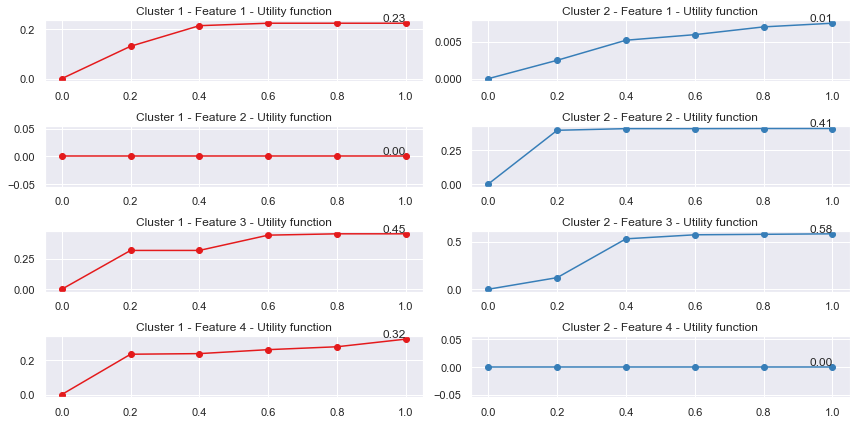

In [7]:
# plot UTA graph
model.plot_UTA()

In [16]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[ 0.15231676 -0.0120235 ]
 [ 0.13141129 -0.36785107]
 [ 0.09054769 -0.44282913]
 [-0.03505462  0.25961298]
 [ 0.10486492 -0.00954725]]


In [17]:
# Or we can directly use the predict_preference method:
print(model.predict_preference(X, Y)[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]


In [18]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 1.0


In [19]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 1.0
Percentage of explained preferences for all samples: 1.0


In [20]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[0 0 0 1 0]


In [9]:
# Ground truth are also provided:
Z = data_loader.get_ground_truth_labels()
#Z = Z[:400]
# We can see how it compares to our model's predictions:
print(Z[:5])

[0 0 0 1 0]


In [11]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = metrics.ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 1.0
Cluster intersection for all samples: 0.9900250626566416
Cluster intersection for all samples: 0.9900250626566416


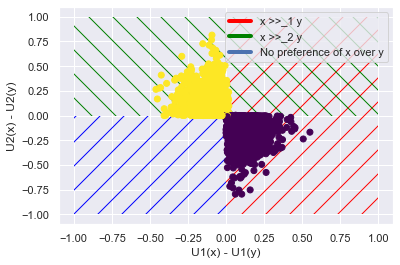

In [15]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z, cmap='viridis')

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

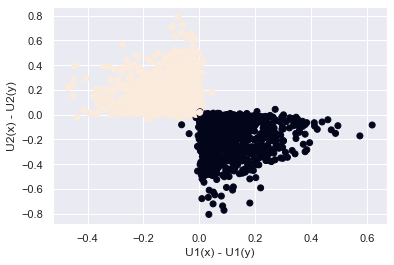

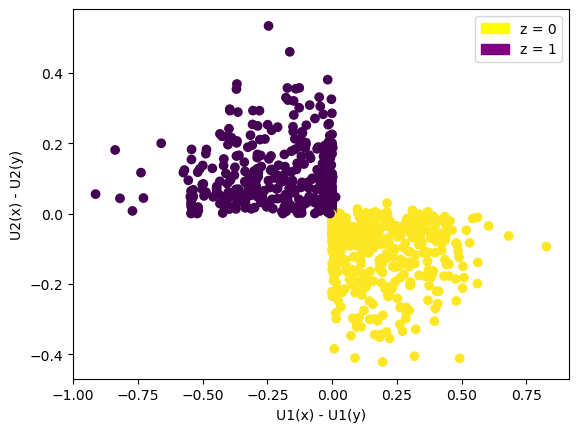

In [15]:
# As an example here are the results obtained with:
# Uncomment the code to check your results
plt.figure()
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")
plt.show()

# Here is how it should look like
from IPython.display import Image
Image("../images/MIP_results_example.png")